In [1]:
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LogFormatter
import networkx as nx

In [2]:
# County table adapted from: https://en.wikipedia.org/wiki/User:Michael_J/County_table
county_table = pd.read_csv('../input/counties.csv.gz', sep='|', quotechar='"', compression='gzip')

In [3]:
# counties = reader.records()
# county = next(counties)

In [4]:
county_table.head()

,Sort,State,FIPS,County,County Seat(s),Population (2010),Land Area km sq,Land Area mi sq,Water Area km sq,Water Area mi sq,Total Area km sq,Total Area mi sq,Latitude,Longitude
0,1,AL,1001,Autauga,Prattville,54571,1539.582,594.436,25.776,9.952,1565.358,604.388,32.536382,-86.644490
1,2,AL,1003,Baldwin,Bay Minette,182265,4117.522,1589.784,1133.19,437.527,5250.712,2027.311,30.659218,-87.746067
2,3,AL,1005,Barbour,Clayton,27457,2291.819,884.876,50.865,19.639,2342.684,904.515,31.870670,-85.405456
3,4,AL,1007,Bibb,Centreville,22915,1612.481,622.582,9.289,3.587,1621.770,626.169,33.015893,-87.127148
4,5,AL,1009,Blount,Oneonta,57322,1669.962,644.776,15.157,5.852,1685.119,650.628,33.977448,-86.567246


In [5]:
nw_states = ['WA', 'OR', 'ID', 'MT']

In [6]:
nw_counties = county_table[county_table['State'].isin(nw_states)]

In [7]:
nw_counties.head()

,Sort,State,FIPS,County,County Seat(s),Population (2010),Land Area km sq,Land Area mi sq,Water Area km sq,Water Area mi sq,Total Area km sq,Total Area mi sq,Latitude,Longitude
551,552,ID,16001,Ada,Boise,392365,2726.158,1052.576,20.425,7.886,2746.583,1060.462,43.447861,-116.244456
552,553,ID,16003,Adams,Council,3976,3530.299,1363.056,17.392,6.715,3547.691,1369.771,44.884583,-116.431873
553,554,ID,16005,Bannock,Pocatello,82839,2880.035,1111.988,91.801,35.444,2971.836,1147.432,42.692939,-112.228986
554,555,ID,16007,Bear Lake,Paris,5986,2524.681,974.785,193.274,74.623,2717.955,1049.408,42.285833,-111.327445
555,556,ID,16009,Benewah,St. Maries,9285,2011.429,776.617,18.988,7.331,2030.418,783.948,47.218451,-116.633541


In [8]:
yak_detainers = pd.read_csv('../input/YakimaDetainers.csv')

In [9]:
yak_detainers.head()

,Booking ID,Date of Booking,Date of Release,Length of Detention,Charge,County/Family Connections,Country of Origin,Coming from Jail?,Prior Jail Location,Coming from Other County/location?,...,Where (county)?,State,Where (state)?,Released to GEO?,Probable Cause in Deporation,Prior Entry Date,Prior Entry Date.1,Why the Suspect is a priority,Notes,Count
0,NaN,10/1/2016,10/5/2016,4,DUI,NaN,Mexico,No,NaN,No,...,Yakima County,WA,WA,NaN,Biometric Conf,Not listed,NaN,NaN,NaN,1
1,NaN,10/3/2016,10/5/16,2,NaN,NaN,Mexico,Yes,Okanogan County,Yes,...,Okanogan County,WA,WA,NaN,NaN,Known,1/22/15,NaN,NaN,1
2,NaN,10/3/2016,10/5/16,2,Child Molestation,NaN,Mexico,Yes,Franklin CountyDOC,Yes,...,Franklin County,WA,WA,NaN,NaN,Not listed,NaN,NaN,Transported by GEO officer,1
3,NaN,10/4/2016,10/6/16,2,Immigration,NaN,Mexico,No,NaN,Yes,...,Benton County,WA,WA,NaN,NaN,Listed,Unknown,NaN,NaN,1
4,NaN,10/4/2016,10/5,1,NaN,NaN,Mexico,Yes,Chelan County,Yes,...,Chelan County,WA,WA,NaN,Ongoing Removal Proceedings,Not Listed,NaN,NaN,No release reciept given,1


In [10]:
yak_detainers['County'] = yak_detainers['County'].str.replace(' County', '')

In [11]:
g = yak_detainers.groupby(['State', 'County'])['Count'].count()

In [12]:
df = g.reset_index()

In [13]:
df = df.rename({'State': 'State1', 'County': 'County1'}, axis=1)

In [14]:
df['State2'] = 'WA'
df['County2'] = 'Yakima'

In [15]:
df.head()

,State1,County1,Count,State2,County2
0,ID,Ada,104,WA,Yakima
1,ID,Bannock,5,WA,Yakima
2,ID,Blaine,5,WA,Yakima
3,ID,Bonneville,6,WA,Yakima
4,ID,Boundary,1,WA,Yakima


In [16]:
df = df[df['State1'] != 'Unknown']
df = df[df['County1'] != 'Unknown']

In [47]:
edges = df[['County1', 'County2']].values

In [48]:
G = nx.DiGraph()

In [49]:
county_dict = nw_counties.set_index('County').to_dict('index')

In [50]:
pos = {county: (v['Longitude'], v['Latitude'])
       for county, v in
       county_dict.items()}

In [51]:
for row in df.values:
    G.add_edge(row[1], row[4], weight=row[2])

In [52]:
weights = pd.Series([c for (u, v, c) in G.edges.data('weight', default=0)])

In [53]:
G.nodes

NodeView(('Ada', 'Yakima', 'Bannock', 'Blaine', 'Bonneville', 'Boundary', 'Canyon', 'Cassia', 'Elmore', 'Fremont', 'Jefferson', 'Jerome', 'Kootenai', 'Minidoka', 'Owyhee', 'Power', 'Twin Falls', 'Lincoln', 'Toole', 'Yellowstone', 'Umatilla', 'Adams', 'Benton', 'Chelan', 'Douglas', 'Franklin', 'Grant', 'Kittitas', 'Klickitat', 'Okanogan', 'Pierce', 'Snohomish', 'Spokane', 'Stevens', 'Walla Walla', 'Whatcom'))

In [55]:
edge_weights = {edge: G.get_edge_data(edge[0], edge[1])['weight'] for edge in G.edges}

In [56]:
edge_colors = [weight / max(weights) for weight in weights]
edge_alphas = 1

In [57]:
# edges=sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)

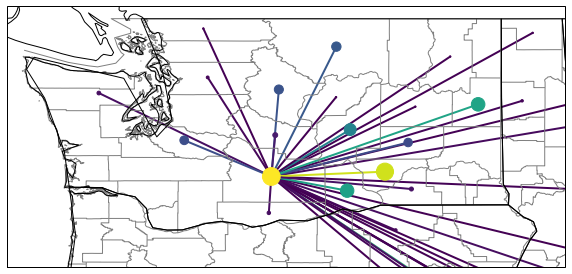

In [109]:
reader = shpreader.Reader('../input/countyl010g.shp')

counties = list(reader.geometries()) # This appears to just be county borders, no other attributes

COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

crs = ccrs.PlateCarree(central_longitude=0.0)

fig, ax = plt.subplots(
    1, 1, figsize=(10, 6),
    subplot_kw=dict(projection=crs))

# ax.add_feature(cfeature.LAND.with_scale('50m'))
# ax.add_feature(cfeature.OCEAN.with_scale('50m'))
# ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(COUNTIES, facecolor='none', edgecolor='gray')
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')

ax.coastlines('50m')

# ax.set_extent([-126, -110, 41, 50]) # PNW 
ax.set_extent([-125, -116, 45, 49.2]) # WA

labels = {county: county for county in G.nodes}

nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=weights*2, node_color=edge_colors)
# nodes = nx.draw_networkx_nodes(G, pos, ax=ax, node_size=15, node_color='black')
edges = nx.draw_networkx_edges(G, pos, ax=ax, node_size=15, arrowstyle='-',
                               arrowsize=20,
                               edge_color=edge_colors,
                               edge_cmap=plt.cm.viridis,
                               width=2)
# edge_labels=nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, label_pos=.5, font_size=12)
# labels = nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=14)

# ax = plt.gca()
# ax.set_axis_off()
plt.show()